In [133]:
import cvxpy as cp
from nldg.utils import *
from nldg.splines import *

In [315]:
data_setting = 6
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=1000, n_hard=1000)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
elif data_setting == 5:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
elif data_setting == 6:
    dtr = gen_data_v7(n=1500)
else:
    dtr = gen_data_v8(n=1500)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Ytr = Ytr - np.mean(Ytr)
dtr['Y'] = Ytr
Etr = np.array(dtr['E'])

## CVXPY

In [316]:
x_min = dtr["X"].min()
x_max = dtr["X"].max()

degree = 3  # cubic splines
n_bases = 10  # number of basis functions

n_internal = n_bases - degree + 1  # number of internal knots
internal_knots = np.linspace(x_min, x_max, n_internal)
knots = np.concatenate((np.repeat(x_min, degree),
                        internal_knots,
                        np.repeat(x_max, degree)))
M = len(knots) - degree - 1

# Compute the penalty matrix using a fine grid over the domain.
grid = np.linspace(x_min, x_max, 400)
Omega = omega(knots, degree, grid)

N = bspline_N(Xtr, knots, degree)
Y_pooled = Ytr

_lambda = 0.01

mask_env0 = (Etr == 0)
mask_env1 = (Etr == 1)

N0 = bspline_N(Xtr[mask_env0], knots, degree)
N1 = bspline_N(Xtr[mask_env1], knots, degree)

Y_env0 = Ytr[mask_env0]
Y_env1 = Ytr[mask_env1]

x_grid = np.linspace(x_min, x_max, 200)

In [317]:
# Classical solution
beta = cp.Variable(M)
objective = cp.Minimize(
    cp.mean(cp.square(Y_pooled - N @ beta)) +
    _lambda * cp.quad_form(beta, Omega)
)
problem = cp.Problem(objective)
problem.solve(solver=cp.SCS)

# Maximin
beta_maximin = cp.Variable(M)
t = cp.Variable(nonneg=True)

constraints = []
constraints.append(cp.mean(cp.square(Y_env0 - N0 @ beta_maximin)) <= t)
constraints.append(cp.mean(cp.square(Y_env1 - N1 @ beta_maximin))<= t)

if data_setting in [2, 5, 6, 7]:
    mask_env2 = (Etr == 2)
    N2 = bspline_N(Xtr[mask_env2], knots, degree)
    Y_env2 = Ytr[mask_env2]
    constraints.append(cp.mean(cp.square(Y_env2 - N2 @ beta_maximin)) <= t)

objective_maximin = cp.Minimize(
    t + _lambda * cp.quad_form(beta_maximin, Omega)
)
problem_maximin = cp.Problem(objective_maximin, constraints)
problem_maximin.solve(solver=cp.SCS)

# Predictions
X_grid = bspline_N(x_grid, knots, degree)

preds_erm = X_grid @ beta.value
preds_maximin = X_grid @ beta_maximin.value

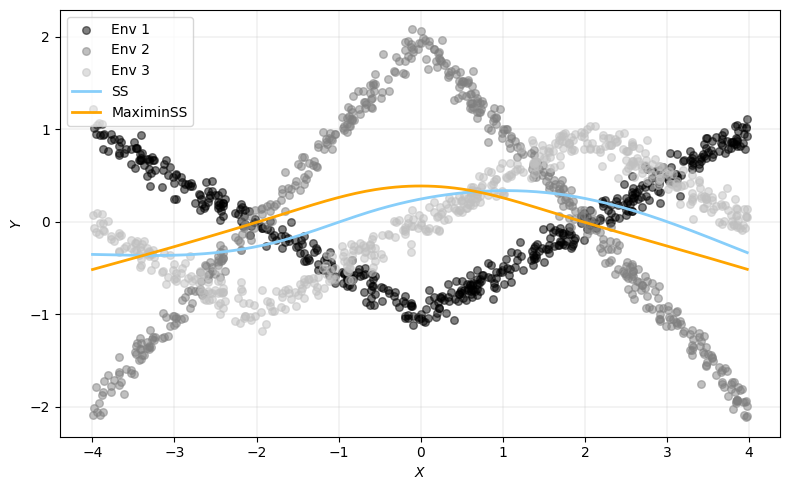

In [318]:
plot_dtr(dtr, x_grid, preds_erm, preds_maximin)

In [263]:
fitted = N @ beta.value
max_mse(Ytr, fitted, Etr, verbose=True)

Environment 0 MSE: 0.6433674389787031
Environment 1 MSE: 0.99376594230517
Environment 2 MSE: 0.18612460433740435


np.float64(0.99376594230517)

In [264]:
fitted_maximin = N @ beta_maximin.value
max_mse(Ytr, fitted_maximin, Etr, verbose=True)

Environment 0 MSE: 0.7776242240127311
Environment 1 MSE: 0.7776237025849405
Environment 2 MSE: 0.3964658191881496


np.float64(0.7776242240127311)

## GDRO algorithm

In [265]:
if data_setting in [2, 5, 6, 7]:
    N_envs = [torch.tensor(N0, dtype=torch.float32),
              torch.tensor(N1, dtype=torch.float32),
              torch.tensor(N2, dtype=torch.float32),]
    Y_envs=[torch.tensor(Y_env0, dtype=torch.float32),
            torch.tensor(Y_env1, dtype=torch.float32),
            torch.tensor(Y_env2, dtype=torch.float32),]
else:
    N_envs=[torch.tensor(N0, dtype=torch.float32),
             torch.tensor(N1, dtype=torch.float32),]
    Y_envs=[torch.tensor(Y_env0, dtype=torch.float32),
            torch.tensor(Y_env1, dtype=torch.float32),]

# does not seem to work for setting 3, setting 5, setting 6
gdro_pars = {1: [0.1, 0.01, 0.01, 3000], 2: [0.01, 0.01, 0.01, 3000], 3: [0.03, 0.01, 0.01, 5000],
             4: [0.1, 0.01, 0.01, 3000], 5: [0.1, 0.01, 0.01, 5000], 6: [0.1, 0.01, 0.01, 4000],
             7: [0.1, 0.01, 0.01, 3000]}

beta_hat, env_weights = train_spline_GDRO(
     N_envs=N_envs,
     Y_envs=Y_envs,
     Omega=torch.tensor(Omega, dtype=torch.float32),
     lr_beta=gdro_pars[data_setting][0],
     eta=gdro_pars[data_setting][1],
     lambda_reg=gdro_pars[data_setting][2],
     epochs=gdro_pars[data_setting][3],
     verbose=True,
     early_stopping=False,
)

Epoch 400: obj=0.751456, best=0.617899
Epoch 800: obj=0.773213, best=0.617899
Epoch 1200: obj=0.777640, best=0.617899
Epoch 1600: obj=0.778589, best=0.617899
Epoch 2000: obj=0.778791, best=0.617899
Epoch 2400: obj=0.778836, best=0.617899
Epoch 2800: obj=0.778846, best=0.617899
Epoch 3200: obj=0.778890, best=0.617899
Epoch 3600: obj=0.778848, best=0.617899
Epoch 4000: obj=0.778864, best=0.617899


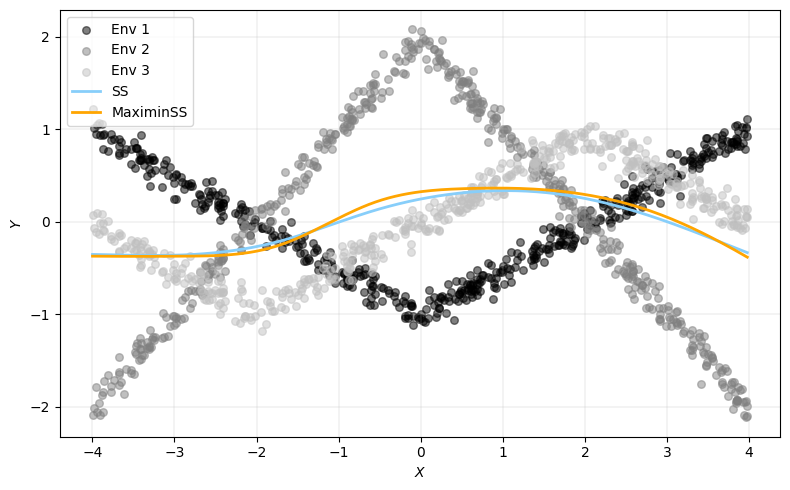

In [267]:
preds_gdro = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_gdro)

In [268]:
fitted_gdro = N @ beta_hat
max_mse(Ytr, fitted_gdro, Etr, verbose=True)

Environment 0 MSE: 0.6883441272090207
Environment 1 MSE: 0.9585191158589658
Environment 2 MSE: 0.17922255457604475


np.float64(0.9585191158589658)

## Extragradient

In [269]:
extragradient_pars = {1: [0.1, 0.01, 3000], 2: [0.075, 0.01, 7000], 3: [0.1, 0.01, 3000],
                      4: [0.1, 0.01, 3000], 5: [0.1, 0.01, 3000], 6: [0.1, 0.01, 3000],
                      7: [0.1, 0.01, 3000]}
# extragradient_pars = {1: [0.1, 0.01, 3000], 2: [0.001, 0.001, 3000], 3: [0.1, 0.01, 3000],
#                       4: [0.1, 0.01, 3000], 5: [0.1, 0.01, 3000], 6: [0.1, 0.01, 3000],
#                       7: [0.1, 0.01, 3000]}

beta_hat, p_hat = train_spline_extragradient(
    N_envs=N_envs,
    Y_envs=Y_envs,
    Omega=torch.tensor(Omega, dtype=torch.float32),
    alpha=extragradient_pars[data_setting][0],
    lambda_reg=extragradient_pars[data_setting][1],
    epochs=extragradient_pars[data_setting][2],
    verbose=True
)

Iter 0/3000: obj=0.748741
Iter 300/3000: obj=0.778802
Iter 600/3000: obj=0.778849
Iter 900/3000: obj=0.778848
Iter 1200/3000: obj=0.778848
Iter 1500/3000: obj=0.778848
Iter 1800/3000: obj=0.778848
Iter 2100/3000: obj=0.778848
Iter 2400/3000: obj=0.778848
Iter 2700/3000: obj=0.778848


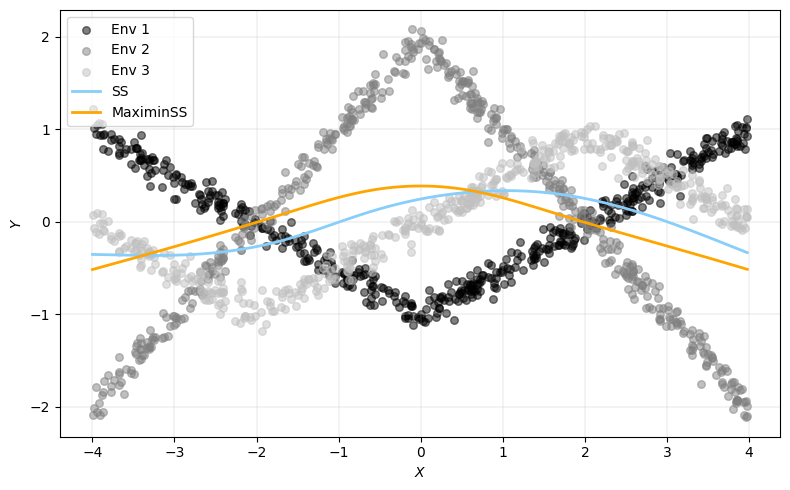

In [270]:
preds_extragradient = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_extragradient)

In [271]:
fitted_extragradient = N @ beta_hat
max_mse(Ytr, fitted_extragradient, Etr, verbose=True)

Environment 0 MSE: 0.7776239339904838
Environment 1 MSE: 0.7776239619518491
Environment 2 MSE: 0.3964631657796093


np.float64(0.7776239619518491)

## GDRO online

In [272]:
# does not seem to work for setting 3, setting 4, setting 6
gdro_on_pars = {1: [0.1, 0.1, 0.01, 8000], 2: [0.075, 0.01, 0.01, 4000], 3: [0.1, 0.1, 0.01, 8000],
                4: [0.1, 0.1, 0.01, 8000], 5: [0.1, 0.1, 0.01, 8000], 6: [0.1, 0.1, 0.01, 8000],
                7: [0.1, 0.1, 0.01, 8000]}

beta_hat, q = train_spline_online_GDRO(
    N_envs=N_envs,
    Y_envs=Y_envs,
    Omega=torch.tensor(Omega, dtype=torch.float32),
    eta=gdro_on_pars[data_setting][0],
    eta_theta=gdro_on_pars[data_setting][1],
    lambda_reg=gdro_on_pars[data_setting][2],
    T=gdro_on_pars[data_setting][3],
    verbose=True,
)

Iter 800/8000: sampled g=0, q_max_idx=0, loss=1.6506, theta_norm=0.8021
Iter 1600/8000: sampled g=2, q_max_idx=0, loss=0.5581, theta_norm=1.4387
Iter 2400/8000: sampled g=0, q_max_idx=0, loss=3.6849, theta_norm=0.9521
Iter 3200/8000: sampled g=2, q_max_idx=1, loss=0.0020, theta_norm=1.0130
Iter 4000/8000: sampled g=1, q_max_idx=0, loss=1.0742, theta_norm=0.8571
Iter 4800/8000: sampled g=1, q_max_idx=0, loss=3.3858, theta_norm=0.5815
Iter 5600/8000: sampled g=2, q_max_idx=0, loss=0.0549, theta_norm=0.7193
Iter 6400/8000: sampled g=1, q_max_idx=1, loss=0.0046, theta_norm=1.0851
Iter 7200/8000: sampled g=1, q_max_idx=1, loss=0.9936, theta_norm=2.2497
Iter 8000/8000: sampled g=0, q_max_idx=1, loss=0.5364, theta_norm=1.1101


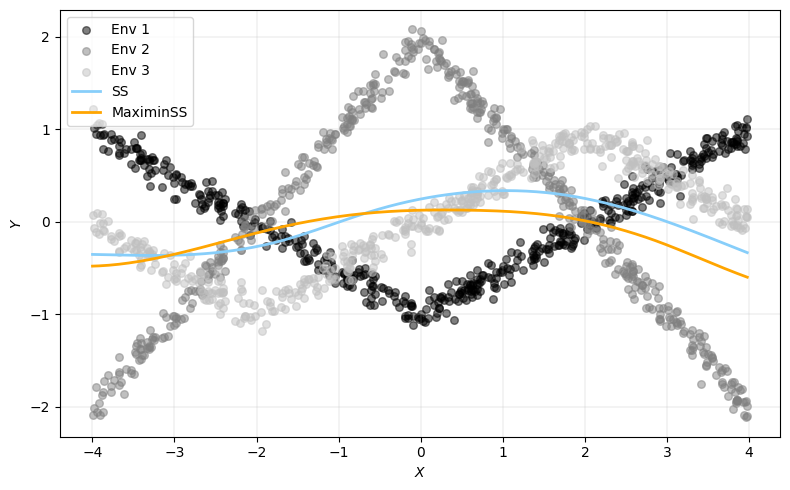

In [273]:
preds_gdro_online = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_gdro_online)

In [274]:
fitted_gdro_online = N @ beta_hat
max_mse(Ytr, fitted_gdro_online, Etr, verbose=True)

Environment 0 MSE: 0.6664154084526267
Environment 1 MSE: 0.92901733307838
Environment 2 MSE: 0.33543861395050845


np.float64(0.92901733307838)

## Subgradient method

In [275]:
# does not work with setting 5
subgradient_pars = {1: [0.1, 0.01, 3000], 2: [0.075, 0.01, 7000], 3: [0.1, 0.01, 3000],
                    4: [0.1, 0.01, 3000], 5: [0.5, 0.01, 7000], 6: [0.1, 0.01, 3000],
                    7: [0.1, 0.01, 3000]}

beta_hat, worst_loss_hist = train_spline_subgradient(
     N_envs=N_envs,
     Y_envs=Y_envs,
     Omega=torch.tensor(Omega, dtype=torch.float32),
     lr=subgradient_pars[data_setting][0],
     lambda_reg=subgradient_pars[data_setting][1],
     epochs=subgradient_pars[data_setting][2],
     verbose=True
)

iter  300  env*=1  MSE*=8.0033e-01  obj≈8.0167e-01
iter  600  env*=1  MSE*=8.0184e-01  obj≈8.0310e-01
iter  900  env*=1  MSE*=8.0137e-01  obj≈8.0262e-01
iter 1200  env*=1  MSE*=8.0129e-01  obj≈8.0255e-01
iter 1500  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01
iter 1800  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01
iter 2100  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01
iter 2400  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01
iter 2700  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01
iter 3000  env*=1  MSE*=8.0128e-01  obj≈8.0254e-01


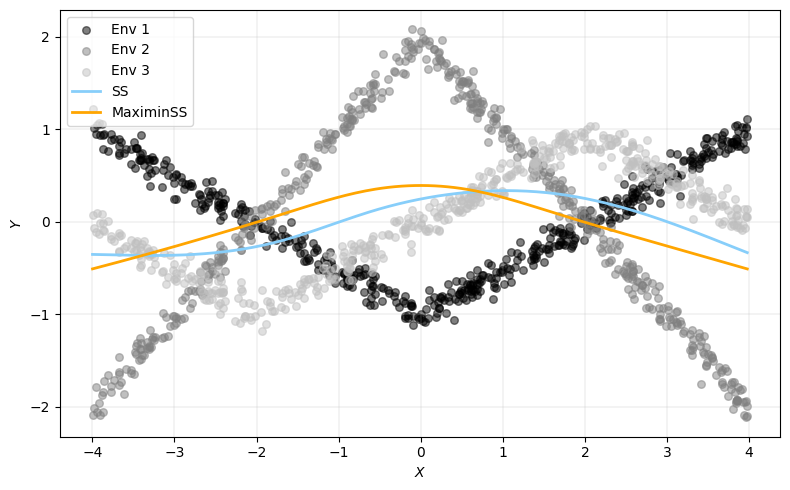

In [276]:
preds_subgradient = X_grid @ beta_hat

plot_dtr(dtr, x_grid, preds_erm, preds_subgradient)

In [277]:
fitted_subgradient = N @ beta_hat
max_mse(Ytr, fitted_subgradient, Etr, verbose=True)

Environment 0 MSE: 0.779551195745649
Environment 1 MSE: 0.7756850928634772
Environment 2 MSE: 0.39691864224089635


np.float64(0.779551195745649)